# Extracting Features with Transformers

The datasets we have used so far have been described in terms of features. In the previous notebooks, we used a transaction-centric dataset. However, ultimately this was just a different format for representing feature-based data.

There are many other types of datasets, including text, images, sounds, movies, or even real objects. Most data mining algorithms, however, rely on having numerical or categorical features. This means we need a way to represent these types before we input them into the data mining algorithm.

The key concepts:
- Extracting features from datasets
- Creating new features
- Selecting good features
- Creating your own transformer for custom datasets

## Feature extraction

Extracting features is one of the most critical tasks in data mining, and **it generally affects your end result more than the choice of data mining algorithm**. Unfortunately, there are no hard and fast rules for choosing features that will result in high performance data mining. In many ways, this is where the science of data mining becomes more of an art. Creating good features relies on intuition, domain expertise, data mining experience, trial and error, and sometimes a little luck.

## Representing reality in models

Not all datasets are presented in terms of features. Sometimes, a dataset consists of nothing more than all of the books that have been written by a given author. Sometimes, it is the film of each of the movies released in 1979. At other times, it is a library collection of interesting historical artifacts.

From these datasets, we may want to perform a data mining task. For the books, we may want to know the different categories that the author writes. In the films, we may wish to see how women are portrayed. In the historical artifacts, we may wantto know whether they are from one country or another. It isn't possible to just pass these raw datasets into a decision tree and see what the result is.

For a data mining algorithm to assist us here, we need to represent these as features. Features are a way to create a model and the model provides an *approximation* of reality in a way that data mining algorithms can understand. Therefore, **a model is just a simplified version of some aspect of the real world**. As an example, the game of chess is a simplified model for historical warfare.

Selecting features has another advantage: they reduce the complexity of the real world into a more manageable model. Imagine how much information it would take to properly, accurately, and fully describe a real-world object to someone that has no background knowledge of the item. You would need to describe the size, weight,
texture, composition, age, flaws, purpose, origin, and so on.

The complexity of real objects is too much for current algorithms, so we use these simpler models instead.

However, there is a downside as this simplification reduces the detail, or may remove good indicators of the things we wish to perform data mining on.

Thought should always be given to how to represent reality in the form of a model. Rather than just using what has been used in the past, you need to consider the goal of the data mining exercise. What are you trying to achieve?

**Note**: Not all features need to be numeric or categorical. Algorithms have been developed that work directly on text, graphs, and other data structures. Unfortunately, those algorithms are outside the scope of
this notebook. In this book, we mainly use numeric or categorical features.

The Adult dataset is a great example of taking a complex reality and attempting to model it using features. In this dataset, the aim is to estimate if someone earns more than $50,000 per year. To download the dataset, navigate to https://archive.ics.uci.edu/ml/datasets/Adult and click on the Data Folder link. Download the
adult.data and adult.names into a directory named Adult in your data folder.


In [1]:
import pandas as pd

DATA = 'data/adult/'
ADULT = DATA + 'adult.data'


In [2]:
adult = pd.read_csv(ADULT, header=None, names=["Age", "Work-Class", "fnlwgt", "Education",
                                                        "Education-Num", "Marital-Status", "Occupation",
                                                        "Relationship", "Race", "Sex", "Capital-gain",
                                                        "Capital-loss", "Hours-per-week", "Native-Country",
                                                        "Earnings-Raw"])

In [3]:
adult.dropna(how='all', inplace=True)
adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

## Common feature patterns

While there are millions of ways to create features, there are some common patterns that are employed across different disciplines. However, choosing appropriate features is tricky and it is worth considering how a feature might correlate to the end result. As the adage says, don't judge a book by its cover—it is probably not worth considering the size of a book if you are interested in the message contained within.

Some commonly used features focus on the physical properties of the real world objects being studied, for example:

- Spatial properties such as the length, width, and height of an object
- Weight and/or density of the object
- Age of an object or its components
- The type of the object
- The quality of the object

Other features might rely on the usage or history of the object:

- The producer, publisher, or creator of the object
- The year of manufacturing
- The use of the object

Other features describe a dataset in terms of its components:

- Frequency of a given subcomponent, such as a word in a book
- Number of subcomponents and/or the number of different subcomponents
- Average size of the subcomponents, such as the average sentence length

Ordinal features allow us to perform ranking, sorting, and grouping of similar values. Features can be numerical or categorical. Numerical features are often described as being **ordinal**. For example, three people, Alice, Bob and Charlie, may have heights of 1.5 m, 1.6 m and 1.7 m. We would say that Alice and Bob are more similar in height than are Alice and Charlie.

In [4]:
adult["Hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours-per-week, dtype: float64

Some of these operations do not make sense for other features. For example, it doesn't make sense to compute the sum of the education statuses.

There are also features that are not numerical, but still ordinal. The *Education* feature in the Adult dataset is an example of this. For example, a Bachelor's degree is a higher education status than finishing high school, which is a higher status than not completing high school. It doesn't quite make sense to compute the mean of these values, but we can create an approximation by taking the median value.

In [5]:
adult["Education-Num"].median()

10.0

The Adult dataset contains several categorical features, with *Work-Class* being one example. While we could argue that some values are of higher rank than others (for instance, a person with a job is likely to have a better income than a person without), it doesn't make sense for all values. For example, a person working for the state government is not more or less likely to have a higher income than someone working in the private sector.

In [6]:
adult["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

Similarly, we can convert numerical features to categorical features through a process called **discretization**. We can call any person who is taller than 1.7 m tall, and any person shorter than 1.7 m short. This gives us a categorical feature (although still an ordinal one). We do lose some data here. For instance, two people, one 1.69 m tall and one 1.71 m, will be in two different categories and considered drastically different from each other. In contrast, a person 1.2 m tall will be considered "of roughly the same height" as the person 1.69 m tall! This loss of detail is a side effect of discretization, and it is an issue that we deal with when creating models.

In the Adult dataset, we can create a LongHours feature, which tells us if a person works more than 40 hours per week. This turns our continuous feature (Hours-per-week) into a categorical one:

In [7]:
adult["LongHours"] = adult["Hours-per-week"] > 40

## Creating good features

Modeling, and the loss of information that the simplification causes, are the reasons why we do not have data mining methods that can just be applied to any dataset. A good data mining practitioner will have, or obtain, domain knowledge in the area they are applying data mining to. They will look at the problem, the available data, and come up with a model that represents what they are trying to achieve.

For instance, a height feature may describe one component of a person, but may not describe their academic performance well. If we were attempting to predict a person's grade, we may not bother measuring each person's height.

This is where data mining becomes more art than science. Extracting good features is difficult and is the topic of significant and ongoing research. Choosing better classification algorithms can improve the performance of a data mining application, but choosing better features is often a better option. In all data mining applications, you should first outline what you are looking for before you start designing the methodology that will find it. This will dictate the types of features you are aiming for, the types of algorithms that you can use, and the expectations on the final result.

## Feature selection
We will often have a large number of features to choose from, but we wish to select
only a small subset. There are many possible reasons for this:

- **Reducing complexity**: Many data mining algorithms need more time and resources with increase in the number of features. Reducing the number of features is a great way to make an algorithm run faster or with fewer resources.
- **Reducing noise**: Adding extra features doesn't always lead to better performance. Extra features may confuse the algorithm, finding correlations and patterns that don’t have meaning (this is common in smaller datasets). Choosing only the appropriate features is a good way to reduce the chance of random correlations that have no real meaning.
- **Creating readable models**: While many data mining algorithms will happily compute an answer for models with thousands of features, the results may be difficult to interpret for a human. In these cases, it may be worth using fewer features and creating a model that a human can understand.

Some classification algorithms can handle data with issues such as these. Getting the data right and getting the features to effectively describe the dataset you are modeling can still assist algorithms. There are some basic tests we can perform, such as ensuring that the features are at least different. If a feature's values are all same, it can't give us extra information to perform our data mining.

The *VarianceThreshold* transformer in scikit-learn, for instance, will remove any feature that doesn't have at least a minimum level of variance in the values. To show how this works, we first create a simple matrix using NumPy:

In [8]:
import numpy as np
X = np.arange(30).reshape((10, 3))

In [9]:
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29]])

In [10]:
X[:,1] = 1

In [11]:
X

array([[ 0,  1,  2],
       [ 3,  1,  5],
       [ 6,  1,  8],
       [ 9,  1, 11],
       [12,  1, 14],
       [15,  1, 17],
       [18,  1, 20],
       [21,  1, 23],
       [24,  1, 26],
       [27,  1, 29]])

In [12]:
from sklearn.feature_selection import VarianceThreshold

In [13]:
vt = VarianceThreshold()
Xt = vt.fit_transform(X)

In [14]:
Xt

array([[ 0,  2],
       [ 3,  5],
       [ 6,  8],
       [ 9, 11],
       [12, 14],
       [15, 17],
       [18, 20],
       [21, 23],
       [24, 26],
       [27, 29]])

In [15]:
print(vt.variances_)

[27.  0. 27.]


## Selecting the best individual features

If we have a number of features, the problem of finding the best subset is a difficult task. It relates to solving the data mining problem itself, multiple times. 

A workaround to this problem is not to look for a subset that works well together, rather than just finding the best individual features. This **univariate** feature selection gives us a score based on how well a feature performs by itself. This is usually done for classification tasks, and we generally measure some type of correlation between a variable and the target class.

The `scikit-learn` package has a number of transformers for performing univariate feature selection. They include `SelectKBest`, which returns the k best performing features, and `SelectPercentile`, which returns the top *r%* of features. In both cases, there are a number of methods of computing the quality of a feature.

There are many different methods to compute how effectively a single feature correlates with a class value. A commonly used method is the chi-squared ($\chi^2$) test. Other methods include mutual information and entropy.
We can observe single-feature tests in action using our Adult dataset. First, we extract a dataset and class values from our pandas DataFrame. We get a selection of the features:

In [16]:
X = adult[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values
y = (adult["Earnings-Raw"] == ' >50K').values

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
transformer = SelectKBest(score_func=chi2, k=3)

In [18]:
Xt_chi2 = transformer.fit_transform(X, y)
print(transformer.scores_)

[8.60061182e+03 2.40142178e+03 8.21924671e+07 1.37214589e+06
 6.47640900e+03]


The highest values are for the first, third, and fourth columns Correlates to the `Age`, `Capital-Gain`, and `Capital-Loss` features. Based on a univariate feature selection, these are the best features to choose.

In [19]:
from scipy.stats import pearsonr

def multivariate_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

We could also implement other correlations, such as the Pearson's correlation coefficient. This is implemented in `SciPy`, a library used for scientific computing (scikit-learn uses it as a base).

In [20]:
transformer = SelectKBest(score_func=multivariate_pearsonr, k=3)
Xt_pearson = transformer.fit_transform(X, y)
print(transformer.scores_)

[0.2340371  0.33515395 0.22332882 0.15052631 0.22968907]


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores_chi2 = cross_val_score(clf, Xt_chi2, y, scoring='accuracy')
scores_pearson = cross_val_score(clf, Xt_pearson, y, scoring='accuracy')

In [22]:
print("Chi2 performance: {0:.3f}".format(scores_chi2.mean()))
print("Pearson performance: {0:.3f}".format(scores_pearson.mean()))

Chi2 performance: 0.829
Pearson performance: 0.772


The `chi2` average here is 0.83, while the Pearson score is lower at 0.77. For this combination, `chi2` returns better results!

## Feature creation

Sometimes, just selecting features from what we have isn't enough. We can create features in different ways from features we already have. The one-hot encoding method. Instead of having a category features with options A, B and C, we would create three new features Is it A?, Is it B?, Is it C?.

Creating new features may seem unnecessary and to have no clear benefit—after all, the information is already in the dataset and we just need to use it. However, some algorithms struggle when features correlate significantly, or if there are redundant features. For this reason, there are various ways to create new features from the features we already have.

We are going to load a new dataset. Download the Advertisements dataset from https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements and save it to your Data folder.

In [23]:
import pandas as pd
import numpy as np
from collections import defaultdict


DATA = 'data/internet_advertisements/'
ADS = DATA + 'ad.data'
ADS_NAMES = DATA + 'ad.names'

def convert_number(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

converters = defaultdict(convert_number)  #{i: convert_number for i in range(1558)}
converters[1558] = lambda x: 1 if x.strip() == "ad." else 0
    
ads = pd.read_csv(ADS, header=None, converters=converters)
ads.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Remove mixed data types in some columns (a simple approach)

Notice and error that indicated column 3 has mixed types of '?'. Here is one way to remove the mixed values.

In [24]:
# find mixed data type columns (assuming the default values are numerical)
cols_to_fix = []
for col in ads.columns:
    try:
        ads[col].astype(float)
    except:
        cols_to_fix.append(col)
    
print(cols_to_fix)

[0, 1, 2, 3]


In [25]:
# find all mixed values from each column with the form '?'
question_marks = set()
for col in cols_to_fix:
    vals_in_columns = ads[col].value_counts().index
    for val in vals_in_columns:
        if '?' in str(val):
            question_marks.add(val)

print(list(question_marks))

['     ?', '?', '   ?']


In [26]:
ads.shape

(3279, 1559)

In [27]:
for col in cols_to_fix:
    ads = ads[~ads[col].isin(question_marks)]
ads.shape

(2359, 1559)

This dataset describes images on websites, with the goal of determining whether a given image is an advertisement or not.

The features in this dataset are not described well by their headings. There are two files accompanying the ad.data file that have more information: ad.DOCUMENTATION and ad.names. The first three features are the height, width, and ratio of the image size. The final feature is 1 if it is an advertisement and 0 if it is not.

The other features are 1 for the presence of certain words in the URL, alt text, or caption of the image. These words, such as the word sponsor, are used to determine if the image is likely to be an advertisement. Many of the features overlap considerably, as they are combinations of other features. Therefore, this dataset has a lot of redundant information.

In [28]:
#ads = ads.astype(float).dropna()
X = ads.drop(1558, axis=1).values
y = ads[1558]

X.shape
y.shape

(2359,)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X, y, scoring='accuracy')
print(f"The average score is {np.mean(scores):.4f}")

The average score is 0.9394


## Principal Component Analysis

In some datasets, features heavily correlate with each other. For example, the speed and the fuel consumption would be heavily correlated in a go-kart with a single gear. While it can be useful to find these correlations for some applications, data mining algorithms typically do not need the redundant information.

The ads dataset has heavily correlated features, as many of the keywords are repeated across the alt text and caption.

The **Principal Component Analysis (PCA)** aims to find combinations of features that describe the dataset in less information. It aims to discover principal components, which are features that do not correlate with each other and explain the information—specifically the **variance**—of the dataset. What this means is that we
can often capture most of the information in a dataset in fewer features.

We apply PCA just like any other transformer. It has one key parameter, which is the number of components to find. By default, it will result in as many features as you have in the original dataset. However, these principal components are ranked—the first feature explains the largest amount of the variance in the dataset, the second a little less, and so on. Therefore, finding just the first few features is often enough to
explain much of the dataset.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Xd = pca.fit_transform(X)

In [31]:
Xd.shape

(2359, 5)

In [32]:
np.set_printoptions(precision=3, suppress=True)
pca.explained_variance_ratio_

array([0.854, 0.145, 0.001, 0.   , 0.   ])

In [33]:
pca.components_[0]

array([0.092, 0.995, 0.024, ..., 0.   , 0.   , 0.   ])

The result, `array([ 0.854, 0.145, 0.001, 0. , 0. ])`, shows us that the first feature accounts for 85.4 percent of the variance in the dataset, the second accounts for 14.5 percent, and so on. By the fourth feature, less than one-tenth of a percent of the variance is contained in the feature. The other 1,553 features explain even less.

The downside to transforming data with PCA is that these features are often complex combinations of the other features. For example, the first feature of the preceding code starts with `[0.092, 0.995, 0.024]`, that is, multiply the first feature in the original dataset by 0.092, the second by 0.995, the third by 0.024. This feature has 1,558 values of this form, one for each of the original datasets (although many are zeros).

In [34]:
clf = DecisionTreeClassifier(random_state=14)
scores_reduced = cross_val_score(clf, Xd, y, scoring='accuracy')
print(f"The average score from the reduced dataset is {np.mean(scores_reduced):.4f}")

The average score from the reduced dataset is 0.9364


The resulting score is 0.9356, which is (slightly) higher than our original score using all of the original features. PCA won't always give a benefit like this, but it does more often than not.

**Note:** We are using PCA here to reduce the number of features in our dataset. **As a general rule, you shouldn't use it to reduce overfitting in your data mining experiments.** The reason for this is that PCA doesn't take classes into account. A better solution is to use **regularization**.

Another advantage is that PCA allows you to plot datasets that you otherwise couldn't easily visualize. For example, we can plot the first two features returned by PCA.

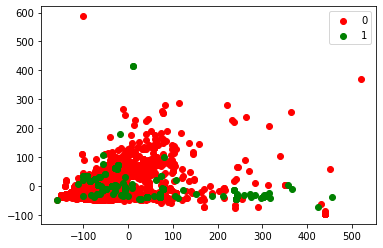

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt
classes = set(y)
colors = ['red', 'green']
for cur_class, color in zip(classes, colors):
    mask = (y == cur_class).values
    plt.scatter(Xd[mask,0], Xd[mask,1], marker='o', color=color, label=int(cur_class))
plt.legend()
plt.show()

## Creating your own transformer

As the complexity and type of dataset changes, you might find that you can't find an existing 
feature extraction transformer that fits your needs.

A transformer is akin to a converting function. It takes data of one form as input and returns 
data of another form as output. Transformers can be trained using some training dataset, and these trained parameters can be used to convert testing data. The transformer API is quite simple. It takes data of a specific format as input and returns data of another format (either the same as the input or different) as output.

## The transformer API

Transformers have two key functions:

- `fit()`: This takes a training set of data as input and sets internal parameters
- `transform()`: This performs the transformation itself. This can take either the training dataset, or a new dataset of the same format

Both `fit()` and `transform()` fuction should take the same data type as input, but
transform() can return data of a different type.

We are going to create a trivial transformer to show the API in action. The transformer will take a NumPy array as input, and discretize it based on the mean. Any value higher than the mean (of the training data) will be given the value 1 and any value lower or equal to the mean will be given the value 0.

## Implementation

In [36]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array

class MeanDiscrete(TransformerMixin):
    def fit(self, X, y=None):
        X = as_float_array(X)
        self.mean = np.mean(X, axis=0)
        return self

    def transform(self, X):
        X = as_float_array(X)
        assert X.shape[1] == self.mean.shape[0]
        return X > self.mean

In [37]:
mean_discrete = MeanDiscrete()
X_mean = mean_discrete.fit_transform(X)

## Unit testing

When creating your own functions and classes, it is always a good idea to do unit testing. Unit testing aims to test a single unit of your code. In this case, we want to test that our transformer does as it needs to do. Good tests should be independently verifiable. A good way to confirm the legitimacy of your tests is by using another computer language or method to
perform the calculations. Unit tests should also be small and quick to run. Therefore, any data used should be of a small size. To create our unit test, we import the assert_array_equal function from NumPy's testing, which checks whether two arrays are equal:

In [39]:
%%file adult_tests.py
import numpy as np
from numpy.testing import assert_array_equal

def test_meandiscrete():
    X_test = np.array([[ 0,  2],
                        [ 3,  5],
                        [ 6,  8],
                        [ 9, 11],
                        [12, 14],
                        [15, 17],
                        [18, 20],
                        [21, 23],
                        [24, 26],
                        [27, 29]])
    mean_discrete = MeanDiscrete()
    mean_discrete.fit(X_test)
    assert_array_equal(mean_discrete.mean, np.array([13.5, 15.5]))
    X_transformed = mean_discrete.transform(X_test)
    X_expected = np.array([[ 0,  0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 0, 0],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1],
                            [ 1, 1]])
    assert_array_equal(X_transformed, X_expected)

Overwriting adult_tests.py


## Putting it all together

Now that we have a tested transformer, it is time to put it into action. We create a Pipeline, set the first step to the *MeanDiscrete* transformer, and the second step to a *Decision Tree Classifier*. We then run a cross validation and print out the result. Let's look at the code:

In [40]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('mean_discrete', MeanDiscrete()), 
                     ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, X, y,scoring='accuracy')
print(f"Mean Discrete performance:{scores_mean_discrete.mean():.3f}")

Mean Discrete performance:0.939


The result is 0.939, which is not as good as before, but not bad for simple binary features.